## Bayes rule introduction
based on [training by Allen Downey](https://allendowney.github.io/BayesianDecisionAnalysis/)
This time we will play 4 machines not 1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# re-writing the functions needed from notebook 08_Bayesian.ipynb

# probability of winning
# these can be seen as hypotheses x=0 is a hypothesis of 0% of winning
# x = 100 is a hyposesis of 100% of wining 
xs = np.arange(101)

# prior probability
# at the start each hypothesis is equally probable
p = 1 / len(xs)

prior = pd.Series(p, index=xs)

In [3]:
# useful function to add titles to plot
def decorate(title=""):
    '''function that adds descriptions to axes'''
    plt.xlabel("Probability of winning")
    plt.ylabel("PMF")
    plt.title(title)

In [4]:
# probability of winning
likelihood_win = xs / 100 # because xs are given as integers and prbability should be from 0 to 1

# likelihood of losing
likelihood_loss = 1 - likelihood_win

In [5]:
def update(pmf, data):
    """Update of prior disribution for playing a machine
    
    pmf:    Pandas series representing prior disribution
    data:   string, wither win 'W' or loss 'L'
    """
    if data == "W":
        likelihood = likelihood_win
    else:
        likelihood = likelihood_loss
    
    pmf *= likelihood
    pmf /= pmf.sum()

## Calculations for 4 machines
In order to differentiate the machine, we need to assign to them actual probabilities of winning to have a more favorable machine. But we need to pretend we do not know those probabilities. Otherwise we would choose the best machine and play it.

In [6]:
actual_probs = [0.0, 0.1, 0.2, 0.3]

Now we need to define a function that will allow us to simulate which machine I will play and if I win or lose.

In [7]:
from random import random

def flip(p):
    '''function that will return True if random is less than p'''
    return random() < p 

In [8]:
from collections import Counter

In [9]:
counter = Counter()

def play(i):
    '''Play machine i and retur if I lost or won'''
    counter[i] += 1
    p = actual_probs[i] # here I get given machine actual probability of winning and then I flip with this probability
    if flip(p):
        return "W"
    else:
        return "L"

Let's try to play machine 3, 10 times. I should see about 30% of wins.

In [11]:
for i in range(10):
    outcome = play(3) # play machine 3
    print(outcome, end=" ")

L L L W L L L W W L 

Now I need to create 4 copies of priors for each of the machines

In [23]:
beliefs = [prior.copy() for i in range(4)]

Function that will allow to plot all machines probabilities in a grid

In [24]:
def plot(beliefs, **options):
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label="Machine %s" %i)
        plt.gca().set_yticklabels([])
        plt.legend()
    plt.tight_layout()

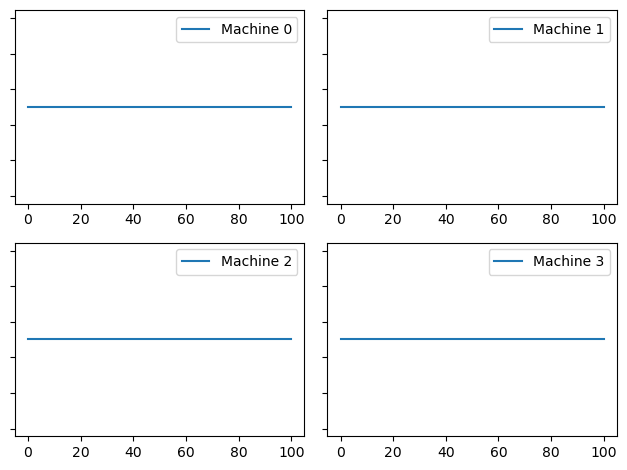

In [25]:
plot(beliefs)

Now let's play each machine 10 times.

In [26]:
for i in range(4): 
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

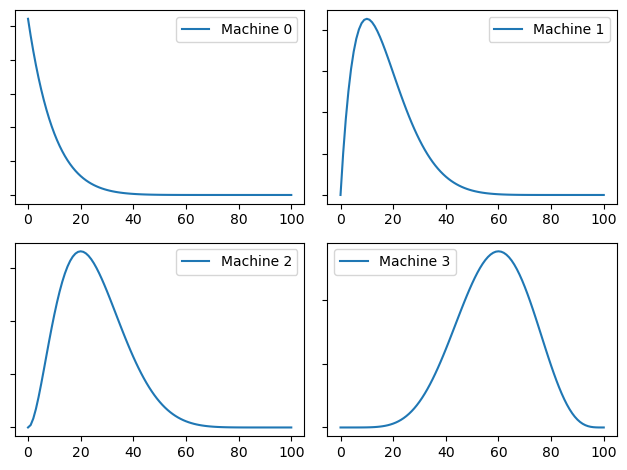

In [27]:
plot(beliefs)

In order to select the best machine to continue playing with it (based on the results from 10 previous plays). We will use what is called a Thompson sampling.
This means that from each of the distribution above a random value is selected and then the machine with the highest value continues to be used for further plays.

In [30]:
def pmf_choice(pmf):
    '''draws a random sample from pmf but not with equal probabilities. Values with higher probabilities will be chosen 
    with a preference'''
    return np.random.choice(a=pmf.index, p=pmf.values)

In [31]:
# example for machine 1
pmf_choice(beliefs[0])

2

In [32]:
# example for machine 4
pmf_choice(beliefs[3])

34

Now we define a function that will select the machine with the highest value returned by a function pmf_choice.

In [33]:
def choose(beliefs):
    '''drawing random sample from distributions for each machine 
    returns the machine number with the highest value'''
    ps = [pmf_choice(b) for b in beliefs]
    return np.argmax(ps)

In [35]:
# example
choose(beliefs)

2

Machines 2 and 3 will pop up most frequently.

Now let's put it all together.

In [39]:
def choose_play_update(beliefs, verbose=False):
    '''Choose a machine, play it and update beliefs
    
    beliefs: list of pmf
    verbose: Boolean to select if to print the results'''
    # choose a machine based on its pmf distribution value
    machine = choose(beliefs)

    # play the machine returning W or L
    outcome = play(machine)

    # update belief based on the outcome
    update(beliefs[machine], outcome)

    if verbose:
        print(machine, outcome)

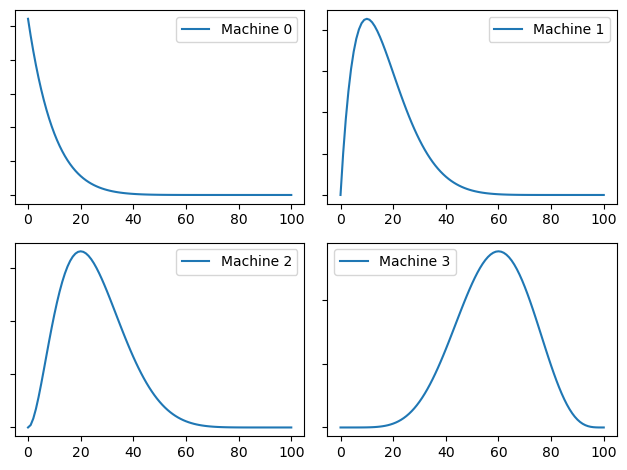

In [37]:
plot(beliefs)

In [46]:
choose_play_update(beliefs, verbose=True)

3 W


### Re-starting fresh with those 4 machines

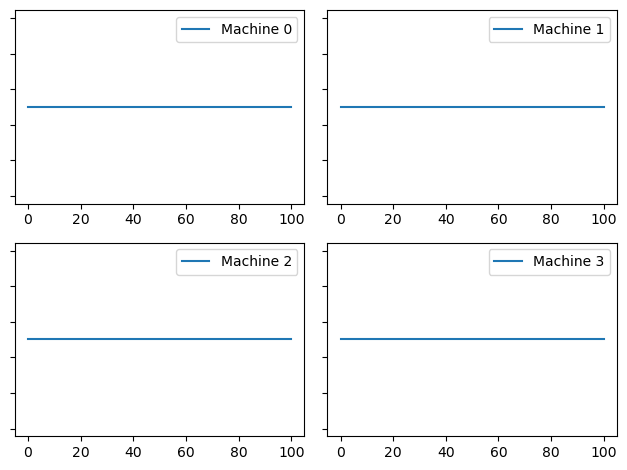

In [54]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()
plot(beliefs)

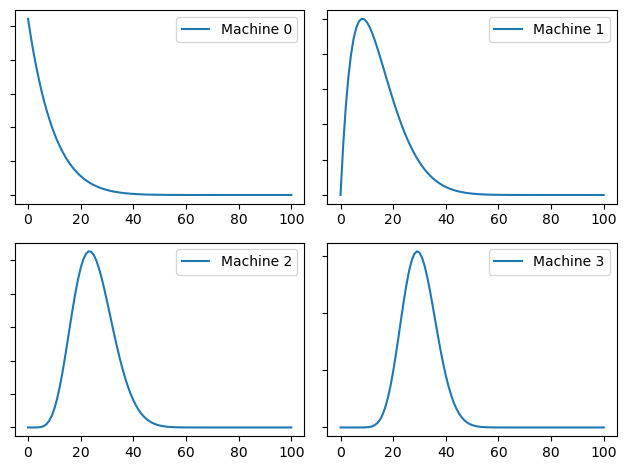

In [55]:
# let's play each machine 100 times

num_plays = 100

for _ in range(num_plays):
    choose_play_update(beliefs)

plot(beliefs)

Let's see how many times I played each machine. Machine 3 should be played most often.

In [56]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 10
1 12
2 30
3 48
